In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale

import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
pd.set_option('display.max_columns', None)
binned_data = pd.read_csv("../data/loaded/processed/ts_processed.csv")
display(binned_data)


,Unnamed: 0,patientunitstayid,offset_bin,eyes,gcs,hr,noninvasivediastolic,noninvasivemean,noninvasivesystolic,resp,sao2,temp,verbal
0,0,172448,0,1.0,1.0,89.090909,81.5,108.0,147.0,14.545455,97.272727,97.5,1.0
1,1,172448,1,1.0,1.0,93.500000,81.5,108.0,147.0,14.583333,96.583333,97.5,1.0
2,2,172448,2,1.0,1.0,92.500000,81.5,108.0,147.0,16.083333,94.750000,97.5,1.0
3,3,172448,3,1.0,1.0,92.416667,81.5,108.0,147.0,17.250000,97.250000,97.5,1.0
4,4,172448,4,1.0,1.0,88.416667,81.5,108.0,147.0,14.916667,97.666667,97.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20323,20323,3351909,19,4.0,6.0,67.000000,66.0,86.0,119.0,23.000000,98.454545,98.9,5.0
20324,20324,3351909,20,4.0,6.0,69.166667,80.0,94.0,125.0,22.429929,98.924242,98.9,5.0
20325,20325,3351909,21,4.0,6.0,66.000000,76.0,95.0,126.0,21.859857,98.409091,98.9,5.0
20326,20326,3351909,22,4.0,6.0,63.250000,72.0,90.0,122.0,21.289786,98.863636,98.9,5.0


[[  699.   125.   105.   396.   958.  2633.]
 [  351.   116.    75.   765.  1881. 11762.]
 [  131.    41.    20.    64.    80.   126.]]
[[ 181.   40.   10.  284.  532. 3287.]
 [ 202.   39.   10.  103.  281. 1294.]
 [ 275.   97.   64.  573. 1488. 8959.]
 [ 130.   40.   20.   63.   70.  117.]
 [ 393.   66.   96.  202.  548.  864.]]


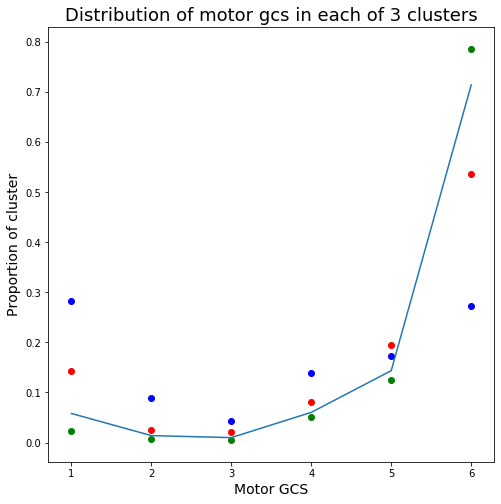

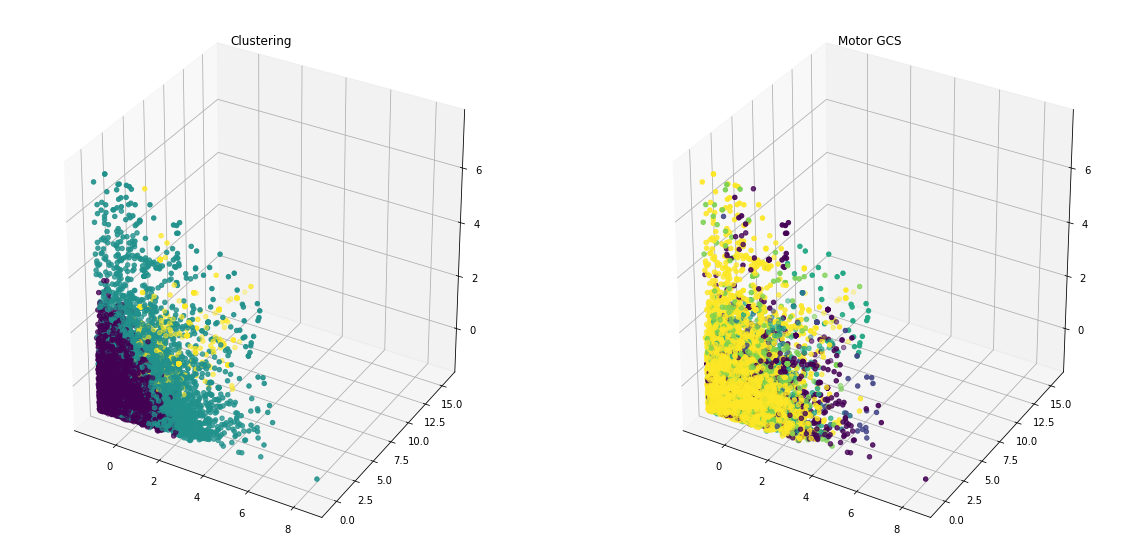

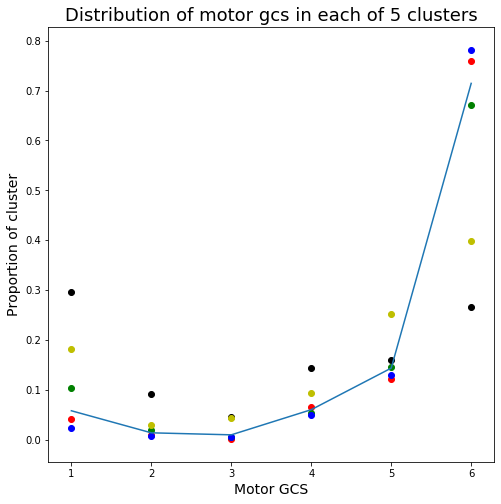

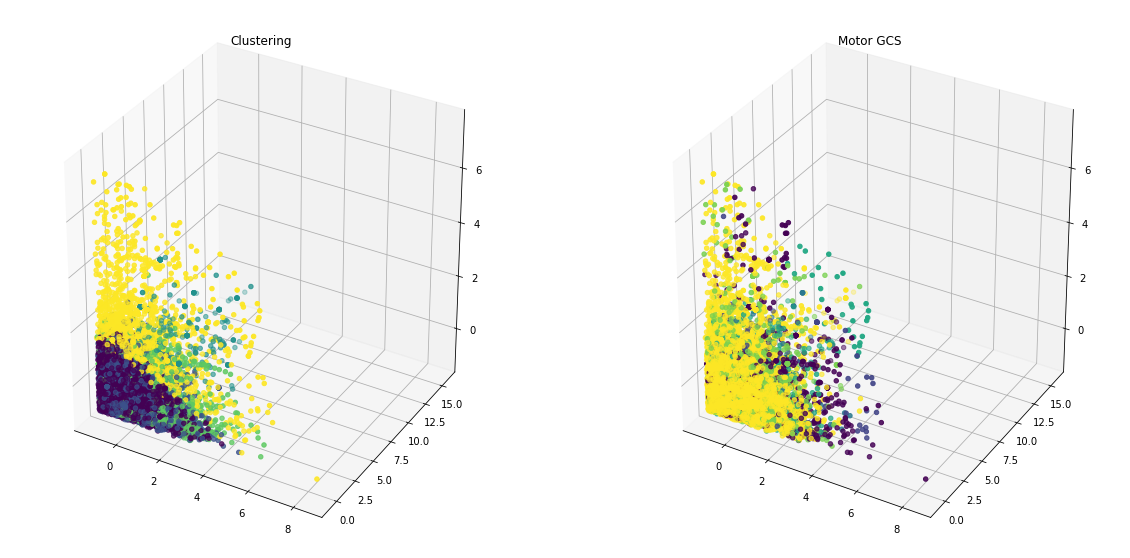

In [117]:
new_df = binned_data[['hr', 'sao2','resp','temp', 'noninvasivemean', 'verbal', 'eyes', 'gcs']]
new_df = new_df.dropna()

#predictors
v = new_df.values[:, :new_df.shape[1]-3]
v2 = v.copy()

for c in np.arange(v2.shape[1]):
    v2[:, c] = np.abs(v2[:, c] - np.median(v2[:, c]))
    
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(v)
v = scaler.transform(v)

scaler.fit(v2)
v2 = scaler.transform(v2)

#labels
g = new_df.values[:, new_df.shape[1]-1]
inertia = []

def plotClusters(v, g, k):
    clustering = KMeans(n_clusters = k)
    cluster_labels = clustering.fit_predict(v)
    
    inertia.append(clustering.inertia_)
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(v[:, 0], v[:, 1], v[:, 2], c = cluster_labels)
    ax.set_title("Clustering")
    
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(v[:, 0], v[:, 1], v[:, 2], c = g)
    ax.set_title("Motor GCS")

def clusterDistributions(v, g, k = 3):
    clustering = KMeans(n_clusters = k)
    cluster_labels = clustering.fit_predict(v)
    a = np.unique(cluster_labels)
    cts = np.zeros((a.shape[0], np.unique(g.astype(int)).shape[0]))
    l = 0
    for i in a:
        inds = np.where(cluster_labels == a[i])[0]
        score, scorects = np.unique(g[inds].astype(int), return_counts = True)
        for j in np.arange(len(score)):
            cts[l, score[j] - 1] = scorects[j]
        l = l + 1
    return cts

def plotGrpDist(grpcts, k = 3, norm = False):
    x = np.arange(grpcts.shape[1]) + 1
    c = ['r', 'g', 'b', 'k', 'y']
    i = 0
    plt.figure(figsize = (8,8))
    dists = []
    for r in np.arange(grpcts.shape[0]):
        dist = grpcts[r, :]
        dist = dist/np.sum(dist)
        dists.append(dist)
        if(norm):
            dist = dist - (np.sum(grpcts, axis = 0)/np.sum(grpcts))
        plt.scatter(x, dist, color = c[i])
        plt.title("Distribution of motor gcs in each of " + str(k) + " clusters", size = 18)
        plt.xlabel("Motor GCS", size = 14)
        plt.ylabel("Proportion of cluster", size = 14)
        i = i + 1
    if not norm:
        plt.plot(x, np.sum(grpcts, axis = 0)/np.sum(grpcts))
    return dists

k = 3
grpcts = clusterDistributions(v2, g, k)
dists1 = plotGrpDist(grpcts, k, norm = False)
plt.savefig('dists1.png', bbox_inches = 'tight')
plotClusters(v2, g, k)
plt.savefig('clusts1.png', bbox_inches = 'tight')
print(grpcts)

k = 5
grpcts = clusterDistributions(v2, g, k)
dists2 = plotGrpDist(grpcts, k, norm = False)
plt.savefig('dists2.png', bbox_inches = 'tight')
plotClusters(v2, g, k)
plt.savefig('clusts2.png', bbox_inches = 'tight')
print(grpcts)



    


In [118]:
from scipy.stats import entropy
def clusterQuality(dists):
    ct = 0
    sums = 0
    for d in dists:
        for j in dists:
            if np.array_equal(d,j):
                continue
            sums += entropy(d, j)
            ct += 1
    return sums/ct

cq1 = clusterQuality(dists1)
cq2 = clusterQuality(dists2)
print(cq1)
print(cq2)
            
        

0.396109339768167
0.31017250764404547


In [1]:
#finds the patient distribution of gcs counts by cluster (need to change bc hard coding indices rn)
clust_dict = {i: np.where(clustering.labels_ == i)[0] for i in range(clustering.n_clusters)}
display(new_df_index)
for key in clust_dict:
    patient_dict = {}
    for val in clust_dict[key]:
        if val in patient_dict: 
           
            patient_dict[new_df_index.iloc[val][3]] += 1
        else:
            #print(val)
            patient_dict[new_df_index.iloc[val][3]] = 0
    plt.bar(list(patient_dict.keys()), patient_dict.values(), color = 'b')
    plt.show()


NameError: name 'clustering' is not defined